# Test some unsupervised methods

In [40]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from fcmeans import FCM

### Start with fuzzy c means

### Get data

In [41]:
data = pd.read_csv('/Users/kristindickerson/00_local/IODP_399/00_workspace/AM_core-log-int/data/U1601C/ResMS_Tree_zscore_FullDataTable.csv')

# Assuming 'data' is your DataFrame
# Step 1: Filter rows where the 'Predicted' column is 'serpentinite' or 'gabbro'
serpentinite_data = data[data['Predicted'] == 'serpentinite']
gabbro_data = data[data['Predicted'] == 'gabbro']

# Step 2: Select only the columns you're interested in for clustering
columns_to_use = ['BulkDensity', 'MagneticSusceptibility', 'NaturalGammaRay', 'Resistivity', 'Vp', 'Vs']
clustering_serp_data = serpentinite_data[columns_to_use]
clustering_gab_data = gabbro_data[columns_to_use]

In [42]:
serpentinite_data_clean = serpentinite_data[columns_to_use].dropna()  # Drop rows with NaNs
gabbro_data_clean = gabbro_data[columns_to_use].dropna()  # Drop rows with NaNs

# Step 3: Normalize the data (optional but recommended)
scaler = StandardScaler()
serpentinite_scaled = scaler.fit_transform(serpentinite_data_clean)
gabbro_scaled = scaler.fit_transform(gabbro_data_clean)

# Function for Fuzzy C-Means and calculating silhouette score
def fcm_and_silhouette(data, n_clusters):
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(data)
    cluster_membership = fcm.predict(data)
    silhouette_avg = silhouette_score(data, cluster_membership)
    return silhouette_avg, fcm.centers, cluster_membership

# Step 4: Optimize the number of clusters using silhouette score and distortions for each dataset
def optimize_clusters(data_scaled, cluster_range):
    silhouette_scores = []
    distortions = []
    for n_clusters in cluster_range:
        silhouette_avg, _, cluster_membership = fcm_and_silhouette(data_scaled, n_clusters)
        silhouette_scores.append(silhouette_avg)
        distortion = fcm.distortion()
        distortions.append(distortion)
    
    return silhouette_scores, distortions

# Optimize clusters for serpentinite
silhouette_scores_serp, distortions_serp = optimize_clusters(serpentinite_scaled, range(2, 10))

# Optimize clusters for gabbro
silhouette_scores_gab, distortions_gab = optimize_clusters(gabbro_scaled, range(2, 10))

# Plot the results for visual inspection
plt.figure(figsize=(12, 5))

# Serpentinite
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), silhouette_scores_serp, 'bo-', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Serpentinite Clustering Optimization')

# Gabbro
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette_scores_gab, 'bo-', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Gabbro Clustering Optimization')

plt.tight_layout()
plt.show()

# Step 5: Assign the final cluster memberships and add them back to the original data
# Choose the optimal number of clusters based on silhouette scores (just an example here)
optimal_clusters_serp = np.argmax(silhouette_scores_serp) + 2  # +2 to match the cluster range starting at 2
optimal_clusters_gab = np.argmax(silhouette_scores_gab) + 2

# Perform final clustering with optimal clusters
_, _, final_serp_membership = fcm_and_silhouette(serpentinite_scaled, optimal_clusters_serp)
_, _, final_gab_membership = fcm_and_silhouette(gabbro_scaled, optimal_clusters_gab)

# Add the cluster membership back to the original cleaned data
serpentinite_data_clean['Cluster'] = final_serp_membership
gabbro_data_clean['Cluster'] = final_gab_membership

# Step 6: Merge the datasets back together with the cluster assignments
final_data = pd.concat([serpentinite_data_clean, gabbro_data_clean])

# Add the cluster column back to the original data
data_with_clusters = data.copy()
data_with_clusters.loc[serpentinite_data_clean.index, 'Cluster'] = final_serp_membership
data_with_clusters.loc[gabbro_data_clean.index, 'Cluster'] = final_gab_membership

# Show the result
print(data_with_clusters.head())

# Save the final dataset with cluster assignments
data_with_clusters.to_csv('/Users/kristindickerson/00_local/IODP_399/00_workspace/AM_core-log-int/results/final_data_with_clusters.csv', index=False)  # Replace with your desired path

NameError: name 'fcm' is not defined

### Fuzzy c means

In [20]:
# Choose which dataset
clutering_data = clustering_serp_data
all_columns = serpentinite_data

# Identify rows with NaNs
nan_mask = clutering_data.isna().any(axis=1)  # Mask for rows with NaNs
# Separate rows without NaNs for clustering
data = clutering_data[~nan_mask]  # Remove rows with NaNs for clustering

# Normalize the data (optional but recommended)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Function for Fuzzy C-Means and calculating silhouette score
def fcm_and_silhouette(data, n_clusters):
    # Fuzzy c means clustering
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)
     # Cluster membership based on max membership values
    cluster_membership = np.argmax(u, axis=0)
    # Silhouette score
    silhouette_avg = silhouette_score(data, cluster_membership)
    return silhouette_avg, cntr, u, cluster_membership

# Optimize the number of clusters
silhouette_scores = []
distortions = []
cluster_range = range(2, 10)

for n_clusters in cluster_range:
    silhouette_avg, cntr, u, cluster_membership = fcm_and_silhouette(data_scaled, n_clusters)
    silhouette_scores.append(silhouette_avg)
     # Calculate distortion based on membership and cluster centers
    distances = np.linalg.norm(data_scaled[:, np.newaxis] - cntr, axis=2) ** 2
    distortion = np.sum(np.min(distances, axis=1)) # Correct distortion calculation
    distortions.append(distortion)


### Plot fuzz c means

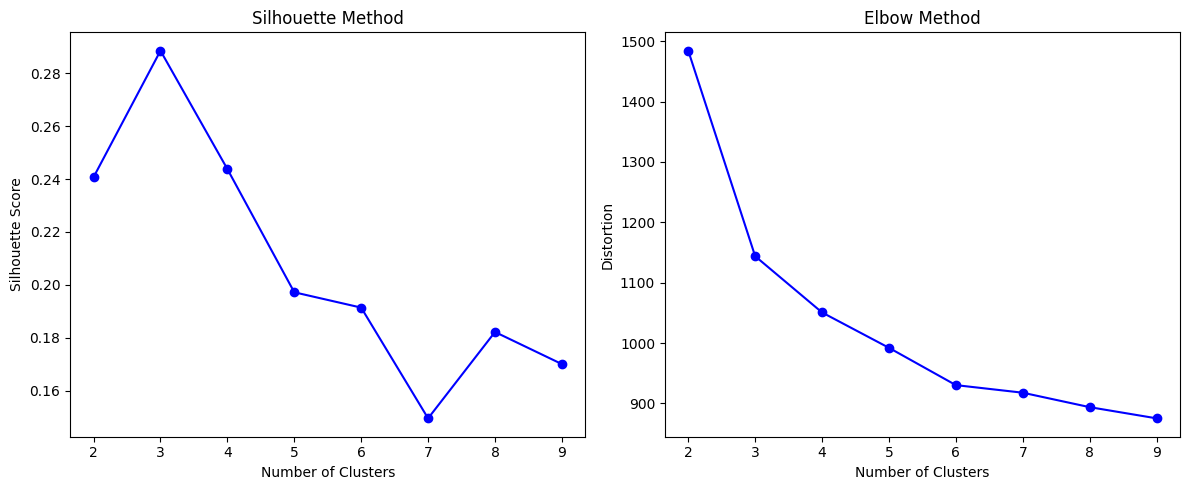

Optimal number of clusters: 3


In [23]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, distortions, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.tight_layout()
plt.show()

# Select the optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {optimal_clusters}')

In [25]:

# Final FCM model with the optimal number of clusters
_, final_cntr, final_u, final_membership = fcm_and_silhouette(data_scaled, optimal_clusters)


In [26]:
# Assign cluster membership back to the serpentinite dataset
clutering_data['Cluster'] = np.nan  # Initialize with NaNs for the cluster column
clutering_data.loc[~clutering_data.isna().any(axis=1), 'Cluster'] = final_membership  # Assign cluster labels for rows with valid data


# Restore original NaNs in the final DataFrame
#data['Cluster'] = final_membership  # Add clusters to original data
print(clutering_data.head())

/var/folders/7g/dgg32wkn3yq399tbv2t26xn40000gn/T/ipykernel_97445/2882933259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clutering_data['Cluster'] = np.nan  # Initialize with NaNs for the cluster column


ValueError: Must have equal len keys and value when setting with an iterable